# Library imports, setup

In [1]:
#if you change a file, you dont have to restart the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from data import load_metadata, visualize_data, make_dataset
from model import build_multitask_model
from score_metrics import get_scores
from loss import SoftF1Loss #custom loss function, currently not used

2025-12-01 16:06:33.557207: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 16:06:33.660531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 16:06:35.064075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")

2.20.0
Found GPU /physical_device:GPU:0, and set memory growth to True.


# Loading data

In [4]:
image_metadata, species_metadata = load_metadata()
NUM_SPECIES = len(species_metadata)

Number of classes: 296


/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["encoded_id"] = encoder.fit_transform(image_metadata["class_id"])
/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["image_path"] = image_metadata["image_path"].apply(


# Visualizing data

In [5]:
#in data.py
#visualize_data(image_metadata)

Loading python images from folder

# Building model

In [6]:
import tensorflow as tf
import keras

In [7]:
from model import build_multitask_model
from score_metrics import get_scores
from loss import SoftF1Loss 

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
IMAGE_RESOLUTION=224
#IMAGE_RESOLUTION=544

NUM_FOLDS = 3


from data import make_batches



X_paths = image_metadata["image_path"].values
y_species = image_metadata["encoded_id"].values

skf = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=42,
)

fold_metrics = []

best_fold_idx = None
best_macro_f1 = -np.inf

all_y_species_true = []
all_y_species_pred = []
all_y_venom_true = []
all_y_venom_pred = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_paths, y_species), start=1):
    print(f"\n===== FOLD {fold_idx}/{NUM_FOLDS} =====")

    train_info = image_metadata.iloc[train_idx].copy()
    val_info   = image_metadata.iloc[val_idx].copy()

    # --- class weight csak a trainre számolva ---
    species_classes = np.unique(train_info["encoded_id"])
    species_cw = compute_class_weight(
        class_weight="balanced",
        classes=species_classes,
        y=train_info["encoded_id"],
    )
    species_cw_dict = {int(c): w for c, w in zip(species_classes, species_cw)}

    species_weight_vec = tf.constant(
        [species_cw_dict[i] for i in range(len(species_cw_dict))],
        dtype=tf.float32,
    )

    # --- tf.data datasetek ---
    train_dataset = make_batches(
        train_info,
        IMAGE_RESOLUTION,
        species_weight_vec=species_weight_vec,
    )

    val_dataset = make_batches(
        val_info,
        IMAGE_RESOLUTION,
        species_weight_vec=None,
    )

    # --- modell: minden foldban újraépítjük ---
    model = build_multitask_model(
        num_species=NUM_SPECIES,
        image_resolution=IMAGE_RESOLUTION,
    )

    lr = 1e-4  # EfficientNetB0-hoz alacsony LR

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=[
            tf.keras.losses.SparseCategoricalCrossentropy(),
            "binary_crossentropy",
        ],
        loss_weights=[1.0, 0.5],
        metrics=["accuracy", "accuracy"],
    )

    # --- callbackek fold-specifikus checkpointtal ---
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"best_model_fold{fold_idx}.keras",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    )

    early_stop_cb = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True,
        verbose=1,
    )

    reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    )

    n_epochs = 5

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=n_epochs,
        callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],
    )

    # --- saját metrikák foldonként, get_scores-szal ---
    metrics_fold = get_scores(
        model,
        image_metadata=image_metadata,
        test_dataset=val_dataset,
        venom_threshold=0.5,
    )

    fold_metrics.append(metrics_fold)

    if metrics_fold["macro_f1"] > best_macro_f1:
        best_macro_f1 = metrics_fold["macro_f1"]
        best_fold_idx = fold_idx

    
    all_y_species_true.append(metrics_fold["y_species_true"])
    all_y_species_pred.append(metrics_fold["y_species_pred"])
    all_y_venom_true.append(metrics_fold["y_venom_true"])
    all_y_venom_pred.append(metrics_fold["y_venom_pred"])

# --- aggregált CV-eredmények (átlag metrikák + összesített predikciók) ---

best_model = keras.models.load_model(
    f"best_model_fold{best_fold_idx}.keras",
    custom_objects={"SoftF1Loss": SoftF1Loss},
)
best_model.save("final_cv_model.keras")

results_own_metrics = {
    "species_accuracy": np.mean([m["species_accuracy"] for m in fold_metrics]),
    "macro_f1": np.mean([m["macro_f1"] for m in fold_metrics]),
    "venom_accuracy": np.mean([m["venom_accuracy"] for m in fold_metrics]),
    "venom_weighted_species_accuracy": np.mean(
        [m["venom_weighted_species_accuracy"] for m in fold_metrics]
    ),
    "y_species_true": np.concatenate(all_y_species_true, axis=0),
    "y_species_pred": np.concatenate(all_y_species_pred, axis=0),
    "y_venom_true": np.concatenate(all_y_venom_true, axis=0),
    "y_venom_pred": np.concatenate(all_y_venom_pred, axis=0),
}

print("\n=== Átlagolt keresztvalidációs eredmények ===")
print(f"Species accuracy (val): {results_own_metrics['species_accuracy']:.4f}")
print(f"Macro-F1 (species, val): {results_own_metrics['macro_f1']:.4f}")
print(f"Venom accuracy (val): {results_own_metrics['venom_accuracy']:.4f}")
print(
    "Venom-weighted species accuracy (val): "
    f"{results_own_metrics['venom_weighted_species_accuracy']:.4f}"
)


I0000 00:00:1764601596.529693    1227 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9



===== FOLD 1/3 =====
Epoch 1/5


2025-12-01 16:06:45.148370: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


 629/1385 ━━━━━━━━━━━━━━━━━━━━ 1:16 101ms/step - loss: 5.9408 - species_accuracy: 0.0091 - species_loss: 5.6899 - venom_accuracy: 0.7730 - venom_loss: 0.5017

2025-12-01 16:07:49.376276: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 5.8076 - species_accuracy: 0.0183 - species_loss: 5.5682 - venom_accuracy: 0.7894 - venom_loss: 0.4788
Epoch 1: val_loss improved from None to 4.97255, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 192s 133ms/step - loss: 5.5696 - species_accuracy: 0.0336 - species_loss: 5.3418 - venom_accuracy: 0.8046 - venom_loss: 0.4547 - val_loss: 4.9726 - val_species_accuracy: 0.0896 - val_species_loss: 4.7662 - val_venom_accuracy: 0.8225 - val_venom_loss: 0.4128 - learning_rate: 1.0000e-04
Epoch 2/5
 494/1385 ━━━━━━━━━━━━━━━━━━━━ 1:34 106ms/step - loss: 4.9764 - species_accuracy: 0.0788 - species_loss: 4.7608 - venom_accuracy: 0.8126 - venom_loss: 0.4312

2025-12-01 16:10:43.034399: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 4.8994 - species_accuracy: 0.0808 - species_loss: 4.6814 - venom_accuracy: 0.8108 - venom_loss: 0.4360
Epoch 2: val_loss improved from 4.97255 to 4.49031, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 198s 143ms/step - loss: 4.7820 - species_accuracy: 0.0867 - species_loss: 4.5635 - venom_accuracy: 0.8106 - venom_loss: 0.4365 - val_loss: 4.4903 - val_species_accuracy: 0.1341 - val_species_loss: 4.2892 - val_venom_accuracy: 0.8272 - val_venom_loss: 0.4019 - learning_rate: 1.0000e-04
Epoch 3/5
 330/1385 ━━━━━━━━━━━━━━━━━━━━ 1:56 111ms/step - loss: 4.4456 - species_accuracy: 0.1180 - species_loss: 4.2265 - venom_accuracy: 0.8127 - venom_loss: 0.4383

2025-12-01 16:13:44.661581: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 4.4408 - species_accuracy: 0.1165 - species_loss: 4.2237 - venom_accuracy: 0.8118 - venom_loss: 0.4342
Epoch 3: val_loss improved from 4.49031 to 4.25869, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 206s 149ms/step - loss: 4.4089 - species_accuracy: 0.1193 - species_loss: 4.1944 - venom_accuracy: 0.8134 - venom_loss: 0.4295 - val_loss: 4.2587 - val_species_accuracy: 0.1552 - val_species_loss: 4.0599 - val_venom_accuracy: 0.8286 - val_venom_loss: 0.3966 - learning_rate: 1.0000e-04
Epoch 4/5
 989/1385 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - loss: 4.2421 - species_accuracy: 0.1416 - species_loss: 4.0251 - venom_accuracy: 0.8132 - venom_loss: 0.4338

2025-12-01 16:18:21.956070: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 4.2290 - species_accuracy: 0.1424 - species_loss: 4.0129 - venom_accuracy: 0.8138 - venom_loss: 0.4323
Epoch 4: val_loss improved from 4.25869 to 4.13571, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 203s 146ms/step - loss: 4.1902 - species_accuracy: 0.1443 - species_loss: 3.9764 - venom_accuracy: 0.8163 - venom_loss: 0.4261 - val_loss: 4.1357 - val_species_accuracy: 0.1694 - val_species_loss: 3.9383 - val_venom_accuracy: 0.8300 - val_venom_loss: 0.3944 - learning_rate: 1.0000e-04
Epoch 5/5
 800/1385 ━━━━━━━━━━━━━━━━━━━━ 1:04 110ms/step - loss: 4.0624 - species_accuracy: 0.1642 - species_loss: 3.8544 - venom_accuracy: 0.8174 - venom_loss: 0.4160

2025-12-01 16:21:25.163197: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 4.0546 - species_accuracy: 0.1638 - species_loss: 3.8456 - venom_accuracy: 0.8171 - venom_loss: 0.4181
Epoch 5: val_loss improved from 4.13571 to 4.03671, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 203s 147ms/step - loss: 4.0372 - species_accuracy: 0.1630 - species_loss: 3.8266 - venom_accuracy: 0.8172 - venom_loss: 0.4208 - val_loss: 4.0367 - val_species_accuracy: 0.1816 - val_species_loss: 3.8411 - val_venom_accuracy: 0.8298 - val_venom_loss: 0.3918 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


2025-12-01 16:24:08.315087: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


=== Evaluation Metrics ===
1) Species accuracy: 0.1816
2) Macro-averaged F1 (species): 0.1625
3) Venom decision accuracy: 0.8298
4) Venom-weighted species accuracy: 0.4787

===== FOLD 2/3 =====
Epoch 1/5
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 5.7991 - species_accuracy: 0.0185 - species_loss: 5.5603 - venom_accuracy: 0.7961 - venom_loss: 0.4776

2025-12-01 16:26:49.697454: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 1: val_loss improved from None to 4.96834, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 205s 142ms/step - loss: 5.5664 - species_accuracy: 0.0333 - species_loss: 5.3405 - venom_accuracy: 0.8057 - venom_loss: 0.4532 - val_loss: 4.9683 - val_species_accuracy: 0.0920 - val_species_loss: 4.7603 - val_venom_accuracy: 0.8215 - val_venom_loss: 0.4168 - learning_rate: 1.0000e-04
Epoch 2/5
1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 4.8992 - species_accuracy: 0.0801 - species_loss: 4.6811 - venom_accuracy: 0.8105 - venom_loss: 0.4362

2025-12-01 16:30:10.554134: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 2: val_loss improved from 4.96834 to 4.47752, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 197s 143ms/step - loss: 4.7715 - species_accuracy: 0.0860 - species_loss: 4.5542 - venom_accuracy: 0.8127 - venom_loss: 0.4335 - val_loss: 4.4775 - val_species_accuracy: 0.1306 - val_species_loss: 4.2732 - val_venom_accuracy: 0.8249 - val_venom_loss: 0.4076 - learning_rate: 1.0000e-04
Epoch 3/5
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 4.4610 - species_accuracy: 0.1150 - species_loss: 4.2464 - venom_accuracy: 0.8143 - venom_loss: 0.4293

2025-12-01 16:34:06.112193: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 3: val_loss improved from 4.47752 to 4.26993, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 197s 142ms/step - loss: 4.4148 - species_accuracy: 0.1176 - species_loss: 4.2011 - venom_accuracy: 0.8160 - venom_loss: 0.4277 - val_loss: 4.2699 - val_species_accuracy: 0.1544 - val_species_loss: 4.0701 - val_venom_accuracy: 0.8268 - val_venom_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 4/5
1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 4.2141 - species_accuracy: 0.1404 - species_loss: 4.0040 - venom_accuracy: 0.8181 - venom_loss: 0.4202

2025-12-01 16:37:14.683044: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 4: val_loss improved from 4.26993 to 4.11986, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 199s 143ms/step - loss: 4.1913 - species_accuracy: 0.1427 - species_loss: 3.9815 - venom_accuracy: 0.8167 - venom_loss: 0.4207 - val_loss: 4.1199 - val_species_accuracy: 0.1711 - val_species_loss: 3.9199 - val_venom_accuracy: 0.8276 - val_venom_loss: 0.3985 - learning_rate: 1.0000e-04
Epoch 5/5
1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 4.0150 - species_accuracy: 0.1611 - species_loss: 3.8067 - venom_accuracy: 0.8184 - venom_loss: 0.4165

2025-12-01 16:39:54.125485: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 5: val_loss improved from 4.11986 to 4.03294, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 199s 143ms/step - loss: 4.0257 - species_accuracy: 0.1602 - species_loss: 3.8169 - venom_accuracy: 0.8181 - venom_loss: 0.4174 - val_loss: 4.0329 - val_species_accuracy: 0.1823 - val_species_loss: 3.8339 - val_venom_accuracy: 0.8289 - val_venom_loss: 0.3962 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


2025-12-01 16:41:19.745193: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data
2025-12-01 16:41:32.267370: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


=== Evaluation Metrics ===
1) Species accuracy: 0.1823
2) Macro-averaged F1 (species): 0.1631
3) Venom decision accuracy: 0.8289
4) Venom-weighted species accuracy: 0.4777

===== FOLD 3/3 =====
Epoch 1/5
 329/1385 ━━━━━━━━━━━━━━━━━━━━ 1:47 101ms/step - loss: 5.9946 - species_accuracy: 0.0057 - species_loss: 5.7218 - venom_accuracy: 0.7325 - venom_loss: 0.5456

2025-12-01 16:42:11.178367: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 5.8116 - species_accuracy: 0.0177 - species_loss: 5.5682 - venom_accuracy: 0.7811 - venom_loss: 0.4869
Epoch 1: val_loss improved from None to 4.97695, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 203s 143ms/step - loss: 5.5875 - species_accuracy: 0.0338 - species_loss: 5.3601 - venom_accuracy: 0.8032 - venom_loss: 0.4546 - val_loss: 4.9770 - val_species_accuracy: 0.0952 - val_species_loss: 4.7697 - val_venom_accuracy: 0.8218 - val_venom_loss: 0.4144 - learning_rate: 1.0000e-04
Epoch 2/5
 454/1385 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - loss: 4.9256 - species_accuracy: 0.0747 - species_loss: 4.7105 - venom_accuracy: 0.8111 - venom_loss: 0.4303

2025-12-01 16:45:42.310834: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 4.8686 - species_accuracy: 0.0796 - species_loss: 4.6523 - venom_accuracy: 0.8118 - venom_loss: 0.4326
Epoch 2: val_loss improved from 4.97695 to 4.47783, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 194s 140ms/step - loss: 4.7887 - species_accuracy: 0.0870 - species_loss: 4.5713 - venom_accuracy: 0.8116 - venom_loss: 0.4339 - val_loss: 4.4778 - val_species_accuracy: 0.1323 - val_species_loss: 4.2758 - val_venom_accuracy: 0.8268 - val_venom_loss: 0.4039 - learning_rate: 1.0000e-04
Epoch 3/5
 173/1385 ━━━━━━━━━━━━━━━━━━━━ 2:11 109ms/step - loss: 4.5177 - species_accuracy: 0.1169 - species_loss: 4.3054 - venom_accuracy: 0.8207 - venom_loss: 0.4247

2025-12-01 16:48:29.190999: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 4.4570 - species_accuracy: 0.1165 - species_loss: 4.2422 - venom_accuracy: 0.8137 - venom_loss: 0.4297
Epoch 3: val_loss improved from 4.47783 to 4.24516, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 189s 136ms/step - loss: 4.4198 - species_accuracy: 0.1190 - species_loss: 4.2052 - venom_accuracy: 0.8139 - venom_loss: 0.4296 - val_loss: 4.2452 - val_species_accuracy: 0.1585 - val_species_loss: 4.0462 - val_venom_accuracy: 0.8281 - val_venom_loss: 0.3989 - learning_rate: 1.0000e-04
Epoch 4/5
1363/1385 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 4.2294 - species_accuracy: 0.1436 - species_loss: 4.0173 - venom_accuracy: 0.8166 - venom_loss: 0.4242

2025-12-01 16:53:35.937158: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 4.2289 - species_accuracy: 0.1436 - species_loss: 4.0168 - venom_accuracy: 0.8165 - venom_loss: 0.4242
Epoch 4: val_loss improved from 4.24516 to 4.10205, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 190s 137ms/step - loss: 4.1967 - species_accuracy: 0.1447 - species_loss: 3.9837 - venom_accuracy: 0.8145 - venom_loss: 0.4266 - val_loss: 4.1021 - val_species_accuracy: 0.1722 - val_species_loss: 3.9029 - val_venom_accuracy: 0.8279 - val_venom_loss: 0.3961 - learning_rate: 1.0000e-04
Epoch 5/5
  84/1385 ━━━━━━━━━━━━━━━━━━━━ 2:00 93ms/step - loss: 4.1254 - species_accuracy: 0.1704 - species_loss: 3.9139 - venom_accuracy: 0.8021 - venom_loss: 0.4230

2025-12-01 16:54:37.670208: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1384/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 4.0377 - species_accuracy: 0.1605 - species_loss: 3.8286 - venom_accuracy: 0.8185 - venom_loss: 0.4182
Epoch 5: val_loss improved from 4.10205 to 4.02610, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 225s 163ms/step - loss: 4.0421 - species_accuracy: 0.1603 - species_loss: 3.8327 - venom_accuracy: 0.8184 - venom_loss: 0.4191 - val_loss: 4.0261 - val_species_accuracy: 0.1823 - val_species_loss: 3.8283 - val_venom_accuracy: 0.8277 - val_venom_loss: 0.3957 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.
=== Evaluation Metrics ===
1) Species accuracy: 0.1823
2) Macro-averaged F1 (species): 0.1654
3) Venom decision accuracy: 0.8277
4) Venom-weighted species accuracy: 0.4805

=== Átlagolt keresztvalidációs eredmények ===
Species accuracy (val): 0.1821
Macro-F1 (species, val): 0.1637
Venom accuracy (val): 0.8288
Venom-weighted species accuracy (val): 0.4790


# Example results

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

def example_results_from_dataset(model, ds, species_names, n_examples=5, venom_threshold=0.5):
    """
    Jelenlegi pipeline:
    ds yield: (img, (species, venom), (species_w, venom_w))
    """

    # csak (img, labels) kell, súlyokat eldobjuk
    ds_vis = ds.map(lambda img, labels, *rest: (img, labels))

    ds_vis = ds_vis.unbatch().shuffle(1000)
    samples = list(ds_vis.take(n_examples))

    imgs = [x[0] for x in samples]   # RAW képek (0–255)
    lbls = [x[1] for x in samples]

    # Modell bemenet előkészítése
    x_raw = tf.stack([tf.cast(img, tf.float32) for img in imgs], axis=0)
    x_for_model = preprocess_input(x_raw)

    pred_species_logits, pred_venom_prob = model.predict(x_for_model, verbose=0)

    plt.figure(figsize=(3.3 * len(imgs), 3.3))
    for i, (img, lbl) in enumerate(zip(imgs, lbls), start=1):
        # lbl: (species, venom)
        species_lbl, venom_lbl = lbl
        true_species = int(species_lbl.numpy())
        true_venom   = int(venom_lbl.numpy())

        pred_species = int(np.argmax(pred_species_logits[i-1]))
        pred_venom   = bool(float(pred_venom_prob[i-1][0]) > venom_threshold)

        true_name = species_names[true_species] if 0 <= true_species < len(species_names) else str(true_species)
        pred_name = species_names[pred_species] if 0 <= pred_species < len(species_names) else str(pred_species)

        plt.subplot(1, len(imgs), i)

        img_np = np.clip(img.numpy(), 0, 255).astype(np.uint8)
        plt.imshow(img_np)
        plt.axis("off")

        plt.title(
            f"True: {true_name} ({'Venom' if true_venom else 'Safe'})\n"
            f"Pred: {pred_name} ({'Venom' if pred_venom else 'Safe'})",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()


2025-12-01 17:02:07.190714: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


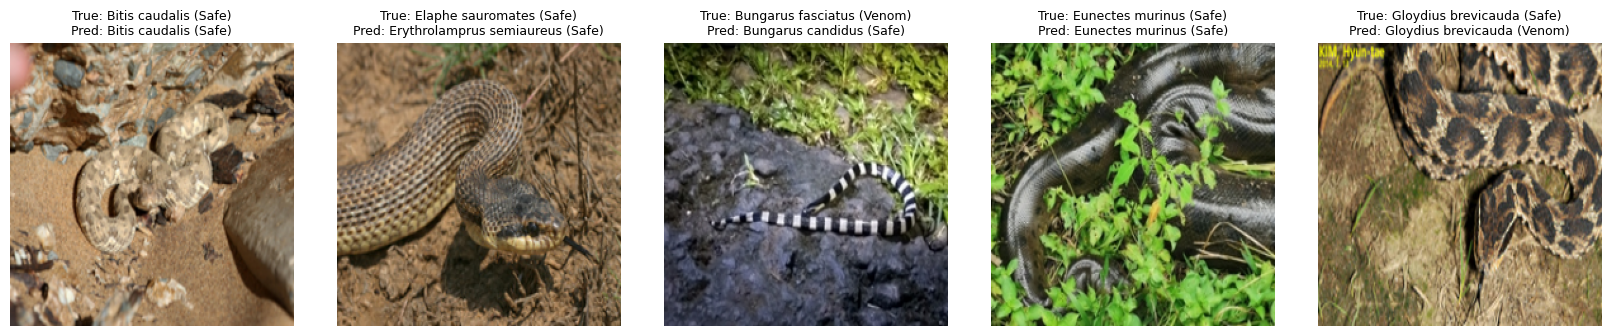

In [15]:
example_results_from_dataset(model, val_dataset, species_metadata, n_examples=5)

# Calculating scoring metrics

Function to tell if the species is venomous or not, based on encoded_id

# Plotting mistakes

In [10]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

def plot_per_class_recall_f1(results):
    y_true = results["y_species_true"]
    y_pred = results["y_species_pred"]

    report = classification_report(y_true, y_pred, output_dict=True)
    class_ids = sorted([int(c) for c in report.keys() if c.isdigit()])

    recalls = [report[str(c)]["recall"] for c in class_ids]
    f1s     = [report[str(c)]["f1-score"] for c in class_ids]

    plt.figure(figsize=(20,6))
    plt.bar(class_ids, recalls)
    plt.title("Per-Class Recall")
    plt.xlabel("Class ID")
    plt.ylabel("Recall")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.bar(class_ids, f1s)
    plt.title("Per-Class F1-Score")
    plt.xlabel("Class ID")
    plt.ylabel("F1")
    plt.show()
import numpy as np

def get_top_confused_pairs(cm, species_names, top_k=20):
    """
    Returns the top most confused class pairs from a confusion matrix.
    
    Args:
        cm: confusion matrix (shape NxN)
        species_names: list mapping class_id -> species name
        top_k: how many confused pairs to return

    Returns:
        A list of dicts with:
            true_id, pred_id, true_name, pred_name, count
    """
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)  # remove correct predictions

    confusions = []

    # Find all non-zero misclassifications
    for true_cls in range(cm_no_diag.shape[0]):
        for pred_cls in range(cm_no_diag.shape[1]):
            count = cm_no_diag[true_cls, pred_cls]
            if count > 0:
                confusions.append((true_cls, pred_cls, count))

    # Sort by count descending
    confusions.sort(key=lambda x: x[2], reverse=True)

    # Build output list
    results = []
    for true_id, pred_id, count in confusions[:top_k]:
        results.append({
            "true_id": true_id,
            "pred_id": pred_id,
            "true_name": species_names[true_id],
            "pred_name": species_names[pred_id],
            "count": count
        })

    return results


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(results):
    y_true = results["y_species_true"]
    y_pred = results["y_species_pred"]

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap='Blues')
    plt.title("Normalized Confusion Matrix")
    plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
plot_per_class_recall_f1(results_own_metrics)

In [ ]:
plot_confusion_matrix(results_own_metrics)